In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("datamunge/sign-language-mnist")

print("Path to dataset files:", path)

100%|██████████| 62.6M/62.6M [00:00<00:00, 86.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1


In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from os import getcwd

In [ ]:
import os

downloaded_files = os.listdir(path)
print(downloaded_files)

['sign_mnist_test', 'american_sign_language.PNG', 'sign_mnist_train', 'sign_mnist_train.csv', 'amer_sign2.png', 'amer_sign3.png', 'sign_mnist_test.csv']


In [ ]:
data_train = pd.read_csv(path + '/sign_mnist_train.csv')
data_test = pd.read_csv(path + '/sign_mnist_test.csv')

In [ ]:
data_train.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149


In [ ]:
data_train.size

21552175

In [ ]:
data_train.shape

(27455, 785)

In [ ]:
training_images = data_train.iloc[:, 1:].values
training_labels = data_train.iloc[:, 0].values

In [ ]:
testing_images = data_test.iloc[:, 1:].values
testing_labels = data_test.iloc[:, 0].values

In [ ]:
training_images = training_images.reshape(-1, 28, 28, 1)
testing_images = testing_images.reshape(-1, 28, 28, 1)

In [ ]:
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(27455, 28, 28, 1)
(27455,)
(7172, 28, 28, 1)
(7172,)


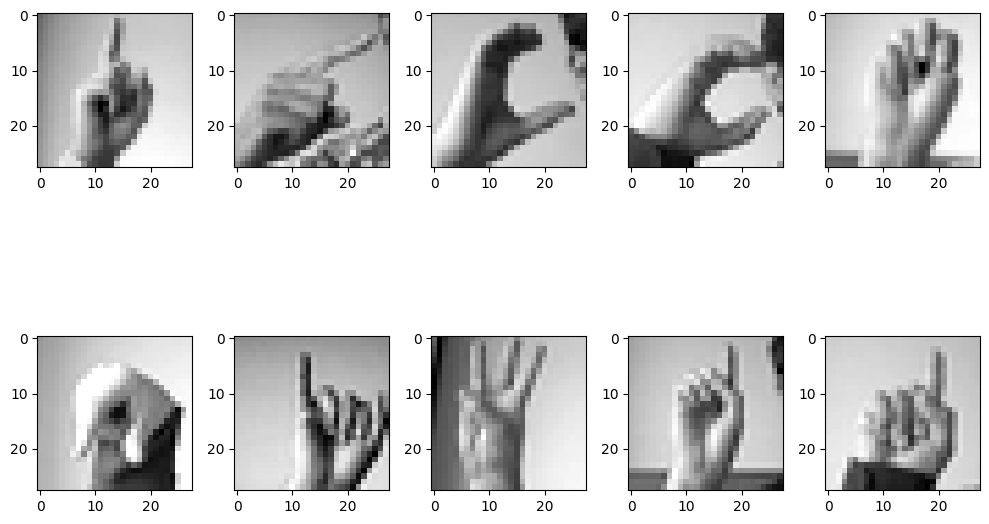

In [ ]:
fig, ax = plt.subplots(2,5)
fig.set_size_inches(10,10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(training_images[k].reshape(28,28), cmap='gray')
        k += 1
    plt.tight_layout()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
print(training_images.shape)
print(testing_images.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


## Training Neural Network

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_datagen.flow(training_images, training_labels, batch_size=32),
    steps_per_epoch=int(len(training_images) / 32),
    epochs=10,
    validation_data=validation_datagen.flow(testing_images, testing_labels, batch_size=32),
    validation_steps=int(len(testing_images) / 32)
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


857/857 ━━━━━━━━━━━━━━━━━━━━ 47s 53ms/step - accuracy: 0.1144 - loss: 2.9399 - val_accuracy: 0.4342 - val_loss: 1.6792
Epoch 2/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 0s 41us/step - accuracy: 0.3125 - loss: 2.2896 - val_accuracy: 0.2500 - val_loss: 1.6511
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


857/857 ━━━━━━━━━━━━━━━━━━━━ 89s 62ms/step - accuracy: 0.3764 - loss: 1.9413 - val_accuracy: 0.5696 - val_loss: 1.2096
Epoch 4/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - accuracy: 0.4688 - loss: 1.5536 - val_accuracy: 0.5000 - val_loss: 0.9119
Epoch 5/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 45s 52ms/step - accuracy: 0.5191 - loss: 1.4790 - val_accuracy: 0.7009 - val_loss: 0.8500
Epoch 6/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.5938 - loss: 1.2853 - val_accuracy: 0.7500 - val_loss: 0.9601
Epoch 7/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.5960 - loss: 1.2096 - val_accuracy: 0.7744 - val_loss: 0.6191
Epoch 8/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.5000 - loss: 1.3162 - val_accuracy: 1.0000 - val_loss: 0.3773
Epoch 9/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.6568 - loss: 1.0389 - val_accuracy: 0.7753 - val_loss: 0.6171
Epoch 10/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.7188 - loss: 0.7188 - val_accuracy: 

In [ ]:
model.evaluate(testing_images, testing_labels, verbose=0)

[211.13038635253906, 0.4804796576499939]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(len(acc))

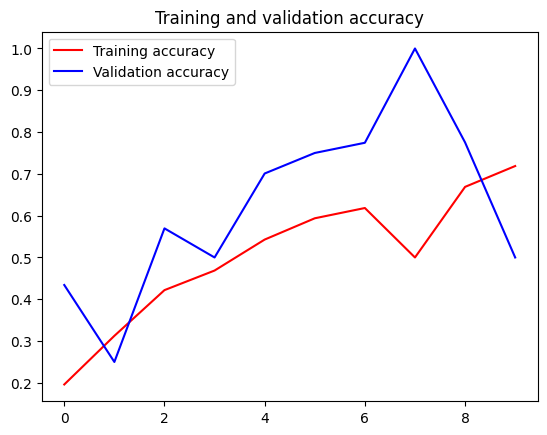

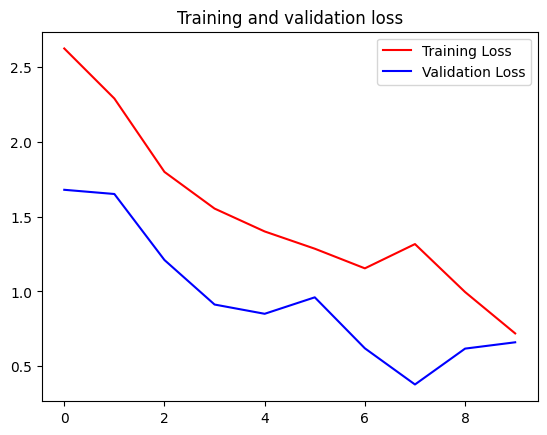

In [ ]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [ ]:
# Predictions
predictions = model.predict(testing_images)  # Get probabilities
predictions = np.argmax(predictions, axis=1)  # Get class labels with highest probability

for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


array([24,  8, 18, 14, 25])

In [ ]:
#Output
#array([ 6,  8, 11, 14, 18])

# Precision, recall, f1-score for all the classes
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
classes = ["Class " + str(i) for i in range(26) if i != 9]
print(classification_report(data_test['label'], predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       0.50      0.66      0.57       331
     Class 1       1.00      0.12      0.21       432
     Class 2       1.00      0.67      0.81       310
     Class 3       0.96      0.10      0.18       245
     Class 4       0.59      0.22      0.33       498
     Class 5       1.00      0.80      0.89       247
     Class 6       0.60      0.06      0.11       348
     Class 7       0.95      0.34      0.50       436
     Class 8       0.84      0.66      0.74       288
    Class 10       0.00      0.00      0.00       331
    Class 11       0.00      0.00      0.00       209
    Class 12       0.00      0.00      0.00       394
    Class 13       0.07      0.14      0.10       291
    Class 14       0.00      0.00      0.00       246
    Class 15       0.00      0.00      0.00       347
    Class 16       0.00      0.00      0.00       164
    Class 17       0.00      0.00      0.00       144
    Class 18       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

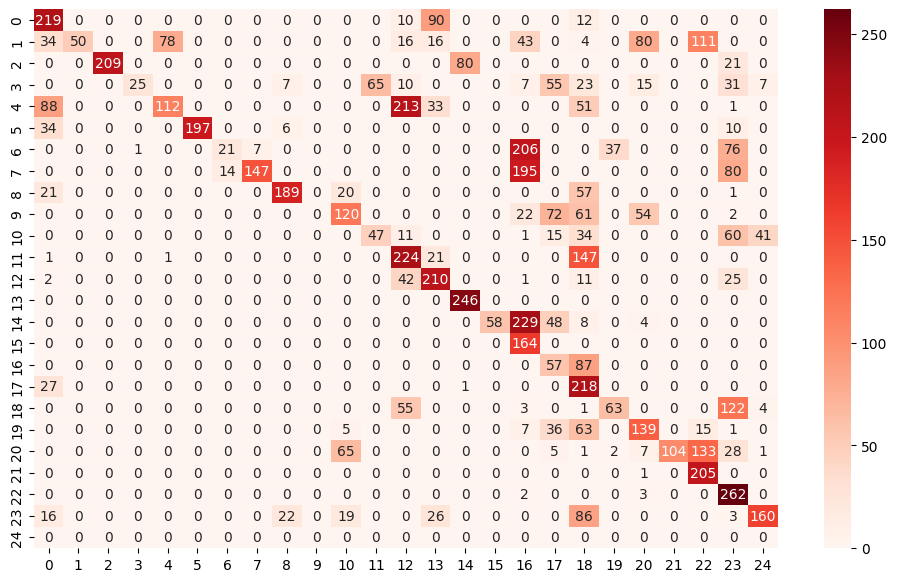

In [ ]:
# Confusion Matrix for the model predictions
cm = confusion_matrix(data_test['label'],predictions)

plt.figure(figsize=(12,7))
g = sns.heatmap(cm, cmap='Reds',annot=True,
           fmt='')